In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
from cuml import ForestInference
import sys
from tqdm import tqdm
import os
import random
from glob import glob
import gc
from multiprocessing import Pool, cpu_count

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle')
from utils.xgb import fit_xgb, inference_xgb
from utils.metric import compute_comptetition_metric
from utils.feature_contena import Features
from utils.pandas_utils import reduce_mem_usage

In [2]:
config = f"""
execution:
    exp_id: exp_005
    debug: False
    submit: False
    multiprocessing: True

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    step_csv_dir: /kaggle/input/save_series_csv/csvs

feature:
    agg_freq: 24 # [step]

xgboost:    
    objective: "binary:logistic"
    learning_rate: 0.1  # 0.01で固定。学習時間とのトレードオフ
    reg_alpha: 0.02  # L1正則化。0.1が推奨。
    reg_lambda: 0.2  # L2正則化。0.1が推奨
    random_state: 42
    max_depth: 5  # 3-8。7くらいでいい。
    colsample_bytree: 0.7  # カラムが多い時は少なめ(0.4とか)にする。
    
seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

CFG["output_dir"] = f"/kaggle/output/{CFG['execution']['exp_id']}"
os.makedirs(CFG["output_dir"], exist_ok=True)

## 特徴生成

In [3]:
def generate_features(train: pd.DataFrame):
    features = Features()

    # 時刻
    timestamp = pd.to_datetime(train["timestamp"].values[0])
    total_seconds = (timestamp - timestamp.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    train["total_seconds"] = (total_seconds + train.index * 5) % (24 * 60 * 60) # [sec]
    features.add_num_feature("total_seconds")    
    
    # センサのラグ特徴量
    dts = [-1000, -500, -300, -100, -50, -30, -10, -5, -3, -2, -1, 1, 2, 3, 5, 10, 30, 50, 100, 300, 500, 1000]
    columns = ["anglez", "enmo"]
    for dt in dts:            
        # diff
        f_names = [f"{c}_diff_{dt}" for c in columns]
        train[f_names] = train[columns].diff(dt)
        features.add_num_features(f_names)

        # rolling
        if dt > 0:
            f_names = [f"{c}_rolling_mean_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).mean()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_std_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).std()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_max_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).max()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_min_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).min()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_median_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).median()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_square_mean_{dt}" for c in columns]
            train[f_names] = ((train[columns] ** 2).rolling(dt, center=True).mean())
            features.add_num_features(f_names)

    # 一定stepで集約
    series_id = train["series_id"].values[0]
    agg_freq = CFG["feature"]["agg_freq"]
    columns = features.all_features() + ["target", "step"]
    train = train[columns].groupby(np.arange(len(train)) // agg_freq).mean()
    train["series_id"] = series_id
    train["target"] = train["target"].round().astype(int)

    train = reduce_mem_usage(train)
    gc.collect()
    return train, features

def read_and_generate_features(file):
    train = pd.read_csv(file)
    train, features = generate_features(train)
    return train, features

In [4]:
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.csv")

if CFG["execution"]["multiprocessing"]:
    with Pool(30) as pool:
        results = list(tqdm(pool.imap(read_and_generate_features, files), total=len(files)))
    dfs, features = zip(*results)
    train = pd.concat(dfs)
    features = features[0]
else:
    dfs = []
    for file in tqdm(files):
        train = pd.read_csv(file)
        train, features = generate_features(train)
        dfs.append(train)
    train = pd.concat(dfs)
    features = features[0]

100%|██████████| 277/277 [15:08<00:00,  3.28s/it]


## 学習

In [5]:
# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train = train.merge(cv_split, on=["series_id"], how="left")
train.head(5)

,anglez_diff_-1,anglez_diff_-10,anglez_diff_-100,anglez_diff_-1000,anglez_diff_-2,anglez_diff_-3,anglez_diff_-30,anglez_diff_-300,anglez_diff_-5,anglez_diff_-50,...,enmo_rolling_std_30,enmo_rolling_std_300,enmo_rolling_std_5,enmo_rolling_std_50,enmo_rolling_std_500,total_seconds,target,step,series_id,fold
0,-0.000200,-0.000708,-0.016125,119.353717,-0.000363,-0.000400,0.003987,4.413438,-0.000587,0.002808,...,0.000000,NaN,0.000000,NaN,NaN,40557.5,1,11.5,af91d9a50547,2
1,-0.000150,-0.000200,-0.015242,89.231321,-0.000154,-0.000154,0.013196,4.154004,-0.000154,0.013483,...,0.000000,NaN,0.000000,0.000000,NaN,40677.5,1,35.5,af91d9a50547,2
2,-0.000675,0.031825,-0.020537,98.292308,-0.000983,-0.001471,-0.005462,94.364600,-0.001838,-0.019917,...,0.000999,NaN,0.000000,0.001634,NaN,40797.5,1,59.5,af91d9a50547,2
3,-0.000208,-0.043421,-0.033788,78.608867,-0.001092,-0.001800,-0.033158,173.490154,-0.003825,-0.030117,...,0.002334,NaN,0.001361,0.002064,NaN,40917.5,1,83.5,af91d9a50547,2
4,-0.000163,0.001538,0.032904,78.833342,-0.000163,-0.000163,0.003292,173.610775,0.001538,-0.002467,...,0.000000,NaN,0.000000,0.000604,NaN,41037.5,1,107.5,af91d9a50547,2


In [6]:
if CFG['execution']['submit']:
    # 推論
    models = [
        ForestInference.load(
            os.path.join(CFG["model_dir"], f'xgb_fold{i}.model'),
            output_class=True,
            model_type='xgboost'
        ) for i in range(CFG.n_fold)]
    pred = inference_xgb(models, train[features])
else:
    # 学習
    trn_oof, models = fit_xgb(train[features.all_features()], train["target"], train["fold"].astype(
        int), params=CFG["xgboost"], es_rounds=50)
    train["oof"] = trn_oof

    # 保存
    for i, model in enumerate(models):
        model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-logloss:0.62027
[50]	eval-logloss:0.15703
[100]	eval-logloss:0.14992
[150]	eval-logloss:0.14769
[200]	eval-logloss:0.14660
[250]	eval-logloss:0.14622
[300]	eval-logloss:0.14578
[350]	eval-logloss:0.14539
[400]	eval-logloss:0.14522
[450]	eval-logloss:0.14510
[500]	eval-logloss:0.14527
[518]	eval-logloss:0.14539


 20%|██        | 1/5 [24:04<1:36:16, 1444.03s/it]

== fold 1 ==
[0]	eval-logloss:0.62047
[50]	eval-logloss:0.15245
[100]	eval-logloss:0.14293
[150]	eval-logloss:0.13924
[200]	eval-logloss:0.13665
[250]	eval-logloss:0.13555
[300]	eval-logloss:0.13474
[350]	eval-logloss:0.13395
[400]	eval-logloss:0.13290
[450]	eval-logloss:0.13236
[500]	eval-logloss:0.13217
[539]	eval-logloss:0.13224


 40%|████      | 2/5 [49:29<1:14:36, 1492.23s/it]

== fold 2 ==
[0]	eval-logloss:0.61933
[50]	eval-logloss:0.12789
[100]	eval-logloss:0.11719
[150]	eval-logloss:0.11417
[200]	eval-logloss:0.11257
[250]	eval-logloss:0.11164
[300]	eval-logloss:0.11130
[350]	eval-logloss:0.11053
[400]	eval-logloss:0.10989
[450]	eval-logloss:0.10979
[500]	eval-logloss:0.10977
[513]	eval-logloss:0.10973


 60%|██████    | 3/5 [1:13:38<49:04, 1472.10s/it]

== fold 3 ==
[0]	eval-logloss:0.61992
[50]	eval-logloss:0.15299
[100]	eval-logloss:0.14559
[150]	eval-logloss:0.14283
[200]	eval-logloss:0.14128
[250]	eval-logloss:0.14009
[300]	eval-logloss:0.13987
[350]	eval-logloss:0.13917
[400]	eval-logloss:0.13905
[450]	eval-logloss:0.13851
[500]	eval-logloss:0.13843
[550]	eval-logloss:0.13822
[600]	eval-logloss:0.13819
[650]	eval-logloss:0.13817
[700]	eval-logloss:0.13813
[750]	eval-logloss:0.13805
[796]	eval-logloss:0.13841


 80%|████████  | 4/5 [1:50:16<29:18, 1758.88s/it]

== fold 4 ==
[0]	eval-logloss:0.61984
[50]	eval-logloss:0.14442
[100]	eval-logloss:0.13364
[150]	eval-logloss:0.13041
[200]	eval-logloss:0.12849
[250]	eval-logloss:0.12708
[300]	eval-logloss:0.12596
[350]	eval-logloss:0.12530
[400]	eval-logloss:0.12465
[450]	eval-logloss:0.12422
[500]	eval-logloss:0.12380
[550]	eval-logloss:0.12352
[600]	eval-logloss:0.12316
[650]	eval-logloss:0.12275
[700]	eval-logloss:0.12257
[750]	eval-logloss:0.12235
[800]	eval-logloss:0.12228
[850]	eval-logloss:0.12223
[900]	eval-logloss:0.12227
[905]	eval-logloss:0.12227


100%|██████████| 5/5 [2:30:10<00:00, 1802.17s/it]


In [7]:
train = train.drop(columns=features.all_features())
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)
train

,target,step,series_id,fold,oof
0,1,11.5,038441c925bb,2,1.000000
1,1,35.5,038441c925bb,2,0.999995
2,1,59.5,038441c925bb,2,0.999965
3,1,83.5,038441c925bb,2,0.999978
4,1,107.5,038441c925bb,2,0.999973
...,...,...,...,...,...
5331158,1,592283.5,fe90110788d2,2,0.998798
5331159,1,592307.5,fe90110788d2,2,0.999207
5331160,1,592331.5,fe90110788d2,2,0.999770
5331161,1,592355.5,fe90110788d2,2,0.999949


## 予測値の作成

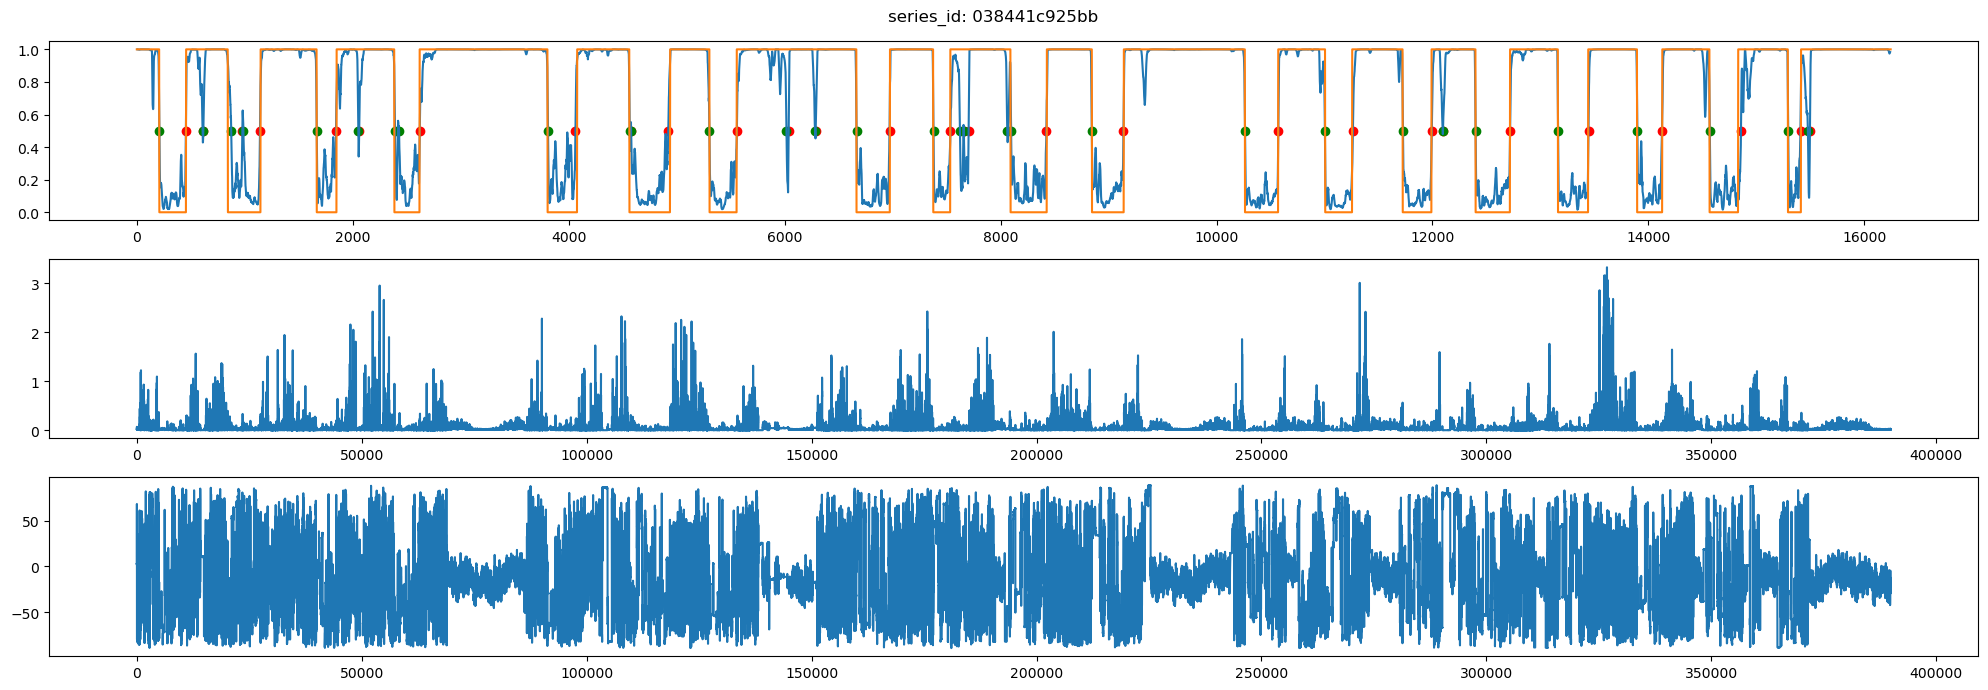

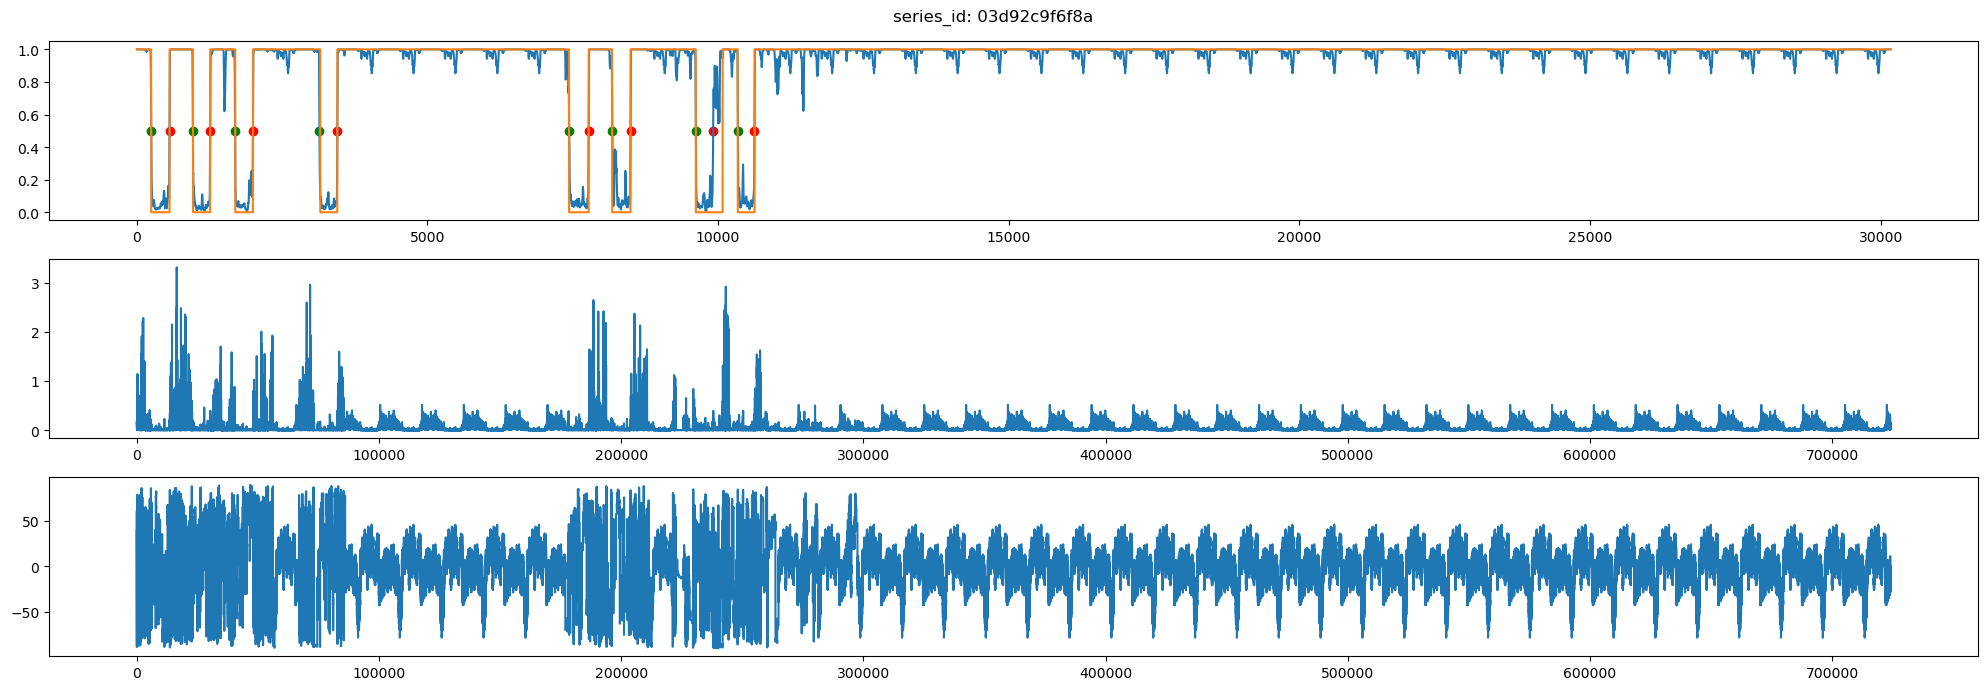

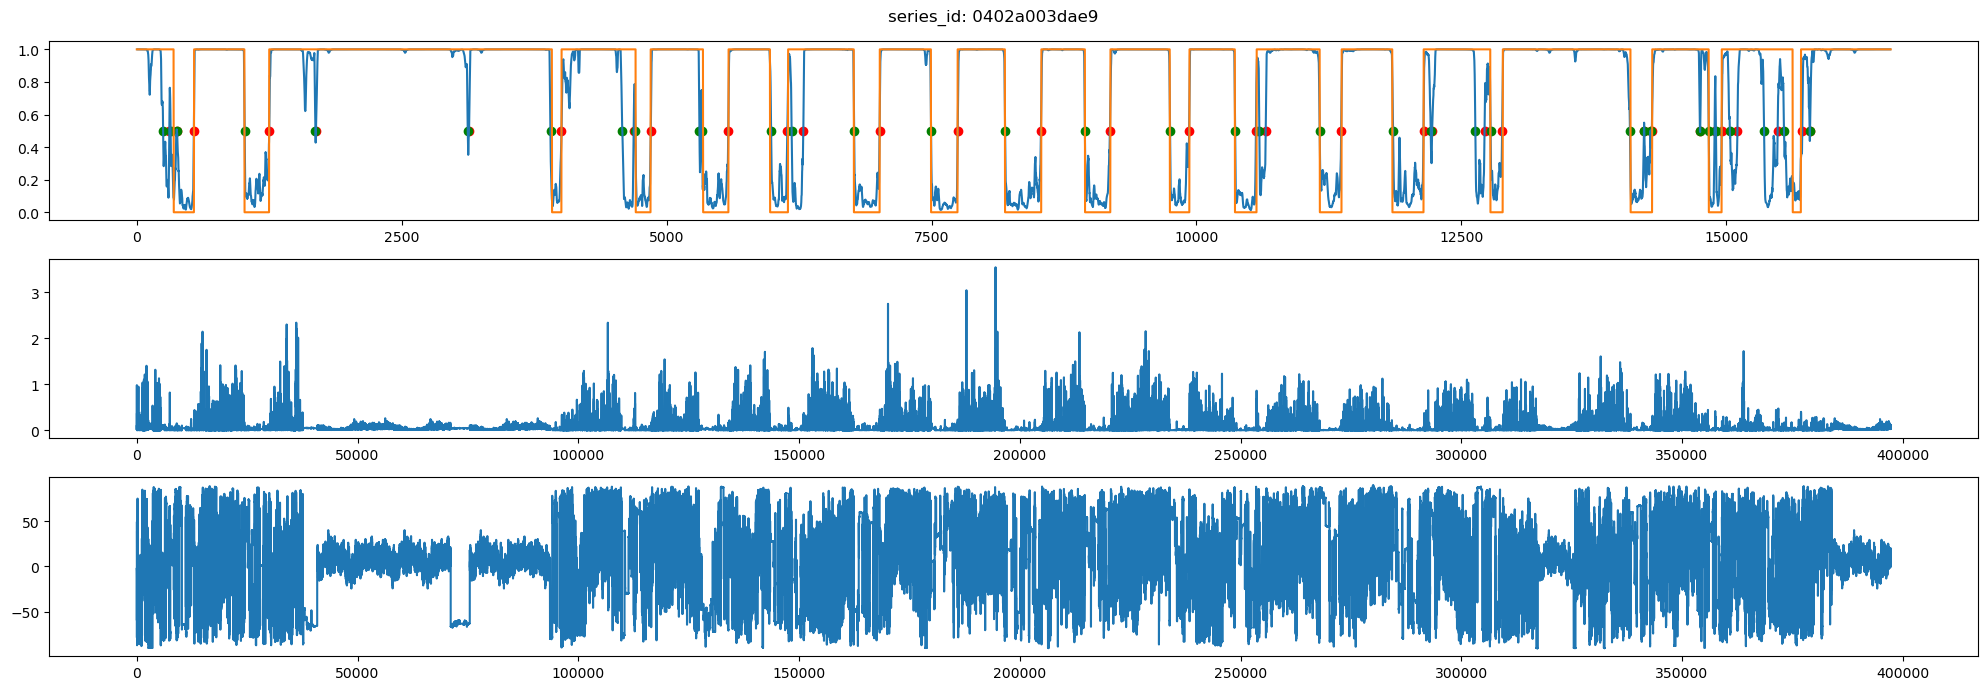

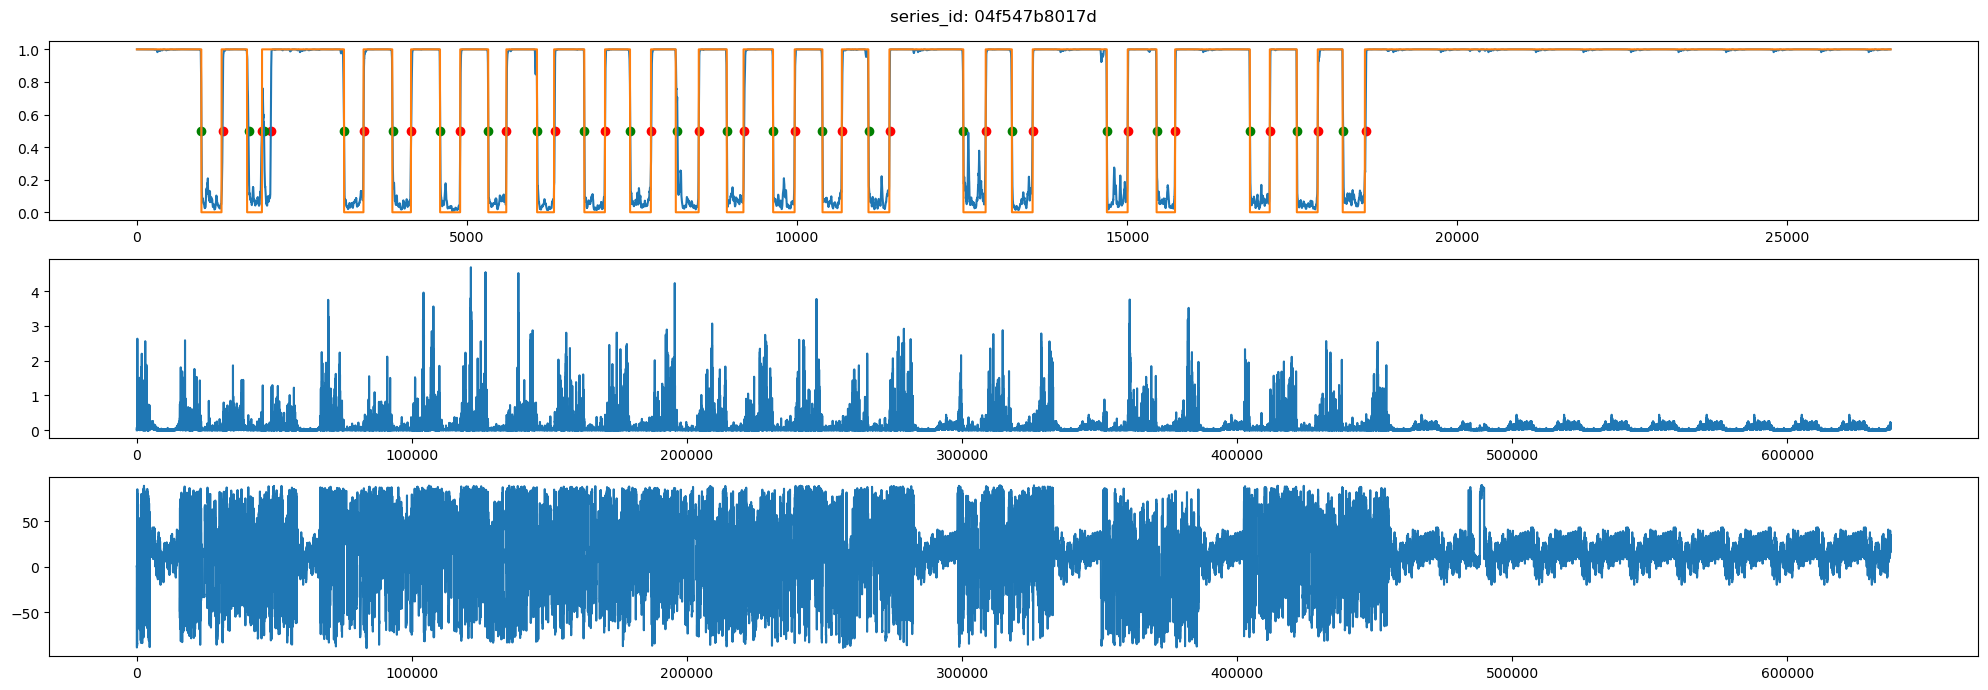

,series_id,step,event,score
0,038441c925bb,10919,wakeup,1
1,038441c925bb,14807,wakeup,1
2,038441c925bb,23471,wakeup,1
3,038441c925bb,27407,wakeup,1
4,038441c925bb,44279,wakeup,1


In [8]:
dfs = []
for series_id, df in train.groupby("series_id"):
    df = df.reset_index(drop=True)
    oof = df["oof"].rolling(12, center=True).mean()
    wakeup_index = np.array([i for i in range(1, len(oof)) if oof[i-1] < 0.5 and oof[i] >= 0.5])
    onset_index = np.array([i for i in range(1, len(oof)) if oof[i-1] > 0.5 and oof[i] <= 0.5])

    sub = pd.concat([
        pd.DataFrame({
            "series_id": series_id,
            "step": df["step"].values[wakeup_index] - CFG["feature"]["agg_freq"] // 2,
            "event": "wakeup",
            "score": 1,
        }),
        pd.DataFrame({
            "series_id": series_id,
            "step": df["step"].values[onset_index] - CFG["feature"]["agg_freq"] // 2,
            "event": "onset",
            "score": 1,
        }),
    ])
    sub["step"] = sub["step"].astype(int)
    dfs.append(sub)

    if len(dfs) < 5:
        fig, axs = plt.subplots(3, 1, figsize=(20, 7))
        axs[0].plot(oof)
        axs[0].plot(df["target"])
        axs[0].scatter(wakeup_index, [0.5 for _ in wakeup_index], c="red")
        axs[0].scatter(onset_index, [0.5 for _ in onset_index], c="green")
        df = pd.read_csv(f"{CFG['dataset']['step_csv_dir']}/{df['series_id'].values[0]}.csv")
        axs[1].plot(df["enmo"])
        axs[2].plot(df["anglez"])
        plt.suptitle(f"series_id: {series_id}")
        plt.tight_layout()
        plt.show()

sub = pd.concat(dfs).reset_index(drop=True)
sub.head()

score: 0.2842


event   tolerance
onset   12           0.005201
        36           0.046399
        60           0.121877
        90           0.215550
        120          0.305857
        150          0.347503
        180          0.383589
        240          0.417590
        300          0.440643
        360          0.460042
wakeup  12           0.011784
        36           0.082650
        60           0.165427
        90           0.256209
        120          0.318608
        150          0.362026
        180          0.385652
        240          0.424025
        300          0.457392
        360          0.476934
dtype: float64

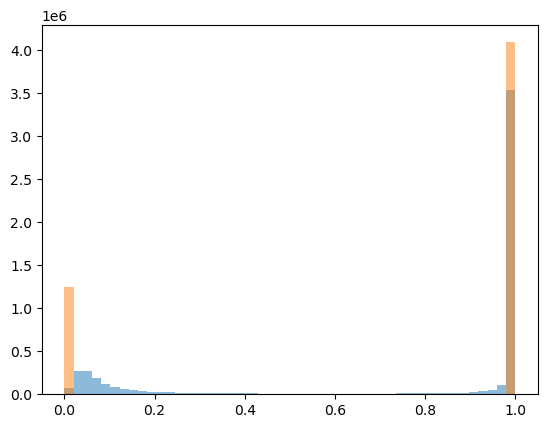

In [9]:
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)
print(f"score: {score:.4f}")
display(ap_table)
plt.hist(train["oof"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.hist(train["target"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.show()

In [10]:
# 次の候補の大きさ
next_cand_size = 0
count = 0
for series_id, train_df in train.groupby("series_id"):
    train_df = train_df[(train_df["oof"] >= 0.1) & (train_df["oof"] <= 0.9)]
    sub_df = sub[(sub["series_id"] == series_id)]
    label_df = labels[labels["series_id"] == series_id]
    pred_steps = train_df["step"].values
    sub_steps = sub_df["step"].values
    label_steps = label_df["step"].values

    next_cand = np.zeros(int(train_df["step"].max()) + CFG["feature"]["agg_freq"])
    for sub_step in sub_steps:
        next_cand[int(sub_step - CFG["feature"]["agg_freq"] * 5): int(sub_step + CFG["feature"]["agg_freq"] * 5)] = 1
    for pred_step in pred_steps:
        next_cand[int(pred_step - CFG["feature"]["agg_freq"] * 5): int(pred_step + CFG["feature"]["agg_freq"] * 5)] = 1
    next_cand_size += np.sum(next_cand)

    for label_step in label_steps:
        if label_step < next_cand.shape[0]:
            count += next_cand[int(label_step)]
recall = count / len(labels)
print(f"recall: {recall:.4f}")
print(f"next_cand_size: {next_cand_size}")

recall: 0.9718
next_cand_size: 29733912.0
